# 신용카드사기탐지 모델

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from sklearnex import patch_sklearn
patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
data = pd.read_csv('./data/fraud.csv')
data.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011,-82.048,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.888,-118.210,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159,-118.186,0


In [4]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

In [5]:
data.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000
mean,417386038393710400.000,70.064,48813.258,38.539,-90.228,88643.675,1358674218.834,38.539,-90.228,0.005
std,1309115265318734848.000,159.254,26881.846,5.071,13.748,301487.618,18195081.388,5.106,13.760,0.072
min,60416207185.000,1.000,1257.000,20.027,-165.672,23.000,1325376018.000,19.027,-166.672,0.000
25%,180042946491150.000,9.640,26237.000,34.669,-96.798,741.000,1343016823.750,34.740,-96.899,0.000
50%,3521417320836166.000,47.450,48174.000,39.354,-87.477,2443.000,1357089331.000,39.369,-87.441,0.000
75%,4642255475285942.000,83.100,72042.000,41.940,-80.158,20328.000,1374581485.250,41.956,-80.245,0.000
max,4992346398065154048.000,28948.900,99921.000,66.693,-67.950,2906700.000,1388534374.000,67.510,-66.951,1.000


In [6]:
# 의미있는 컬럼만 선택
data[['amt', 'city_pop']].describe()

,amt,city_pop
count,1852394.000,1852394.000
mean,70.064,88643.675
std,159.254,301487.618
min,1.000,23.000
25%,9.640,741.000
50%,47.450,2443.000
75%,83.100,20328.000
max,28948.900,2906700.000


In [7]:
# 결측치 없음을 확인
data.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [8]:
# 문자형 / 숫자형으로 구분
data_obj = data.select_dtypes(include='object')
data_num = data.select_dtypes(exclude='object')

In [9]:
data_obj.columns

Index(['trans_date_trans_time', 'merchant', 'category', 'first', 'last',
       'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num'],
      dtype='object')

In [10]:
for col in data_obj:
    print('='*30, col, '='*30)
    print(f'{col}의 unique의 수 = {data_obj[col].nunique()}', end='\n\n')
    print(data_obj[col].value_counts(), end='\n\n')
    
    print(data[[col, 'is_fraud']].groupby(col).mean().sort_values(by='is_fraud', ascending=False), end='\n\n')

============================== trans_date_trans_time ==============================
trans_date_trans_time의 unique의 수 = 1819551

trans_date_trans_time
2019-04-22 16:02:01    4
2020-06-01 01:37:47    4
2020-06-02 12:47:07    4
2020-10-05 19:37:49    4
2020-12-13 17:53:47    4
                      ..
2019-01-01 00:41:45    1
2019-01-01 00:42:26    1
2019-01-01 00:43:38    1
2019-01-01 00:44:20    1
2020-12-31 23:50:17    1
Name: count, Length: 1819551, dtype: int64

                       is_fraud
trans_date_trans_time          
2019-09-11 22:58:11       1.000
2019-12-22 01:09:30       1.000
2019-02-12 23:49:17       1.000
2019-09-23 06:33:47       1.000
2019-05-03 04:38:52       1.000
...                         ...
2019-01-01 00:41:45       0.000
2019-01-01 00:42:26       0.000
2019-01-01 00:43:38       0.000
2019-01-01 00:44:20       0.000
2020-12-31 23:50:17       0.000

[1819551 rows x 1 columns]

============================== merchant ==============================
merchant의 uniqu

                          is_fraud
job                               
Accountant, chartered        1.000
Warehouse manager            1.000
Careers adviser              1.000
Solicitor                    1.000
Ship broker                  1.000
...                            ...
Health physicist             0.001
Contractor                   0.000
Engineer, communications     0.000
Engineer, drilling           0.000
Stage manager                0.000

[497 rows x 1 columns]

============================== dob ==============================
dob의 unique의 수 = 984

dob
1977-03-23    8044
1988-09-15    6574
1981-08-29    6571
1955-05-06    5121
1960-01-13    4395
              ... 
1962-03-14       7
1944-06-17       7
1970-06-25       7
1932-05-09       7
1998-08-02       6
Name: count, Length: 984, dtype: int64

            is_fraud
dob                 
2001-07-17     1.000
2002-03-17     1.000
1925-08-29     1.000
1927-02-03     1.000
1944-05-30     1.000
...              ...
1949-10-04 

In [13]:
# 하나의 카드로 이상거래인 경우만 나오게 된다 -> 범죄에 사용된 경우일 수 있음
print('결제 확인된 건수: ',len(data[data['state'] == 'DE']))
data[data['state'] == 'DE']['cc_num'].unique()

결제 확인된 건수:  9


array([6011826317034777])

obj에서 사용할 컬럼 : 'trans_date_trans_time', 'merchant', 'category', 'gender', 'street', 'city', 'state', 'job', 'dob'

In [19]:
data_num.columns

Index(['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [25]:
from ydata_profiling import ProfileReport

C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
profile = ProfileReport(data, title="Profiling Report")

In [27]:
profile.to_file("is_froad_eda.html")

Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.18it/s]


# EDA
- cc_num의 유니크값 : 999 -> 999명의 거래데이터
- 집 위치와 상점 위치가 서로 연관이 있다

False
2


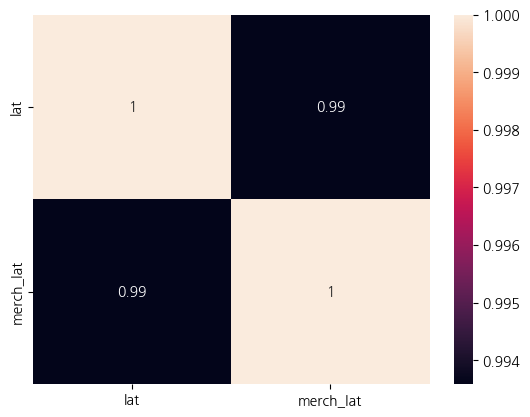

In [14]:
# 고객 거주 지역의 위도와 상점의 위도의 연관성 확인
import matplotlib.pyplot as plt


print((data['lat'] == data['merch_lat']).all())
print((data['lat'] == data['merch_lat']).sum())

corr = data[['lat', 'merch_lat']].corr()
sns.heatmap(corr, annot=True)
plt.show()

False
1


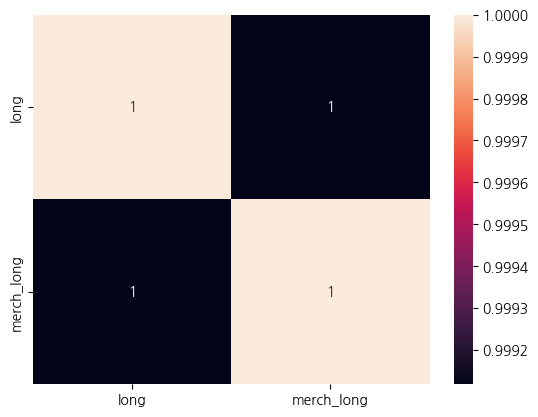

In [15]:
# 고객 거주 지역의 경도와 상점의 경도의 연관성 확인
print((data['long'] == data['merch_long']).all())
print((data['long'] == data['merch_long']).sum())

corr = data[['long', 'merch_long']].corr()
sns.heatmap(corr, annot=True)
plt.show()

In [16]:
# 사용자별로 소비패턴을 분석하면 카드 이상 거래 포착에 용이할 것 
data['cc_num'].nunique()

999

### is_fraud의 비율

In [17]:
# 굉장히 낮은 비율의 이상거래가 존재한다
# 전체 데이터셋의 0.52 % 차지 
data['is_fraud'].mean() * 100

np.float64(0.5210014716091717)

## 카드별(고객별) 거래 금액에서의 이상치를 찾음
- is_fraud와의 관계 확인

-----
### 이상값 탐지
- 1) IQR 활용
- 2) Z-Score 활용

In [18]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [19]:
amt_desc = data.groupby(['cc_num'])['amt'].describe()
amt_desc

,count,mean,std,min,25%,50%,75%,max
cc_num,,,,,,,,
60416207185,2196.000,59.258,142.870,1.020,7.560,36.540,72.802,3437.460
60422928733,2200.000,65.483,92.043,1.010,9.075,51.405,87.085,1290.370
60423098130,738.000,96.376,1000.694,1.010,8.780,35.425,75.463,27119.770
60427851591,743.000,107.488,131.015,8.860,59.140,76.670,99.110,1164.360
60487002085,735.000,64.097,153.208,1.020,8.095,35.670,70.855,2758.460
...,...,...,...,...,...,...,...,...
4958589671582726883,2191.000,67.206,137.504,1.000,8.830,50.130,84.455,4292.860
4973530368125489546,1467.000,75.789,258.847,1.010,9.435,52.660,88.340,8749.440
4980323467523543940,736.000,70.709,119.903,1.010,8.465,42.515,83.458,1327.430


In [20]:
amt_desc.columns

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [21]:
amt_desc['iqr_max'] = amt_desc['75%'] + (1.5 * (amt_desc['75%'] - amt_desc['25%']))
amt_desc

,count,mean,std,min,25%,50%,75%,max,iqr_max
cc_num,,,,,,,,,
60416207185,2196.000,59.258,142.870,1.020,7.560,36.540,72.802,3437.460,170.666
60422928733,2200.000,65.483,92.043,1.010,9.075,51.405,87.085,1290.370,204.100
60423098130,738.000,96.376,1000.694,1.010,8.780,35.425,75.463,27119.770,175.486
60427851591,743.000,107.488,131.015,8.860,59.140,76.670,99.110,1164.360,159.065
60487002085,735.000,64.097,153.208,1.020,8.095,35.670,70.855,2758.460,164.995
...,...,...,...,...,...,...,...,...,...
4958589671582726883,2191.000,67.206,137.504,1.000,8.830,50.130,84.455,4292.860,197.892
4973530368125489546,1467.000,75.789,258.847,1.010,9.435,52.660,88.340,8749.440,206.697
4980323467523543940,736.000,70.709,119.903,1.010,8.465,42.515,83.458,1327.430,195.946


In [22]:
amt_desc = amt_desc.reset_index()
amt_desc

,cc_num,count,mean,std,min,25%,50%,75%,max,iqr_max
0,60416207185,2196.000,59.258,142.870,1.020,7.560,36.540,72.802,3437.460,170.666
1,60422928733,2200.000,65.483,92.043,1.010,9.075,51.405,87.085,1290.370,204.100
2,60423098130,738.000,96.376,1000.694,1.010,8.780,35.425,75.463,27119.770,175.486
3,60427851591,743.000,107.488,131.015,8.860,59.140,76.670,99.110,1164.360,159.065
4,60487002085,735.000,64.097,153.208,1.020,8.095,35.670,70.855,2758.460,164.995
...,...,...,...,...,...,...,...,...,...,...
994,4958589671582726883,2191.000,67.206,137.504,1.000,8.830,50.130,84.455,4292.860,197.892
995,4973530368125489546,1467.000,75.789,258.847,1.010,9.435,52.660,88.340,8749.440,206.697
996,4980323467523543940,736.000,70.709,119.903,1.010,8.465,42.515,83.458,1327.430,195.946
997,4989847570577635369,1471.000,93.009,128.397,1.030,19.940,57.170,111.945,1223.850,249.952


In [23]:
amt_desc.columns

Index(['cc_num', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',
       'iqr_max'],
      dtype='object')

In [24]:
amt_desc.columns = ['cc_num', 'count', 'amt_mean', 'amt_std', 'min', '25%', '50%', '75%', 'max', 'amt_iqr_max']
amt_desc

,cc_num,count,amt_mean,amt_std,min,25%,50%,75%,max,amt_iqr_max
0,60416207185,2196.000,59.258,142.870,1.020,7.560,36.540,72.802,3437.460,170.666
1,60422928733,2200.000,65.483,92.043,1.010,9.075,51.405,87.085,1290.370,204.100
2,60423098130,738.000,96.376,1000.694,1.010,8.780,35.425,75.463,27119.770,175.486
3,60427851591,743.000,107.488,131.015,8.860,59.140,76.670,99.110,1164.360,159.065
4,60487002085,735.000,64.097,153.208,1.020,8.095,35.670,70.855,2758.460,164.995
...,...,...,...,...,...,...,...,...,...,...
994,4958589671582726883,2191.000,67.206,137.504,1.000,8.830,50.130,84.455,4292.860,197.892
995,4973530368125489546,1467.000,75.789,258.847,1.010,9.435,52.660,88.340,8749.440,206.697
996,4980323467523543940,736.000,70.709,119.903,1.010,8.465,42.515,83.458,1327.430,195.946
997,4989847570577635369,1471.000,93.009,128.397,1.030,19.940,57.170,111.945,1223.850,249.952


In [25]:
data = pd.merge(data, amt_desc[['cc_num', 'amt_mean', 'amt_std', 'amt_iqr_max']], how='left', on='cc_num')
data

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011,-82.048,0,89.409,127.530,256.620
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.888,-118.210,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159,-118.186,0,56.078,159.202,158.060
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.181,-112.262,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.151,-112.154,0,69.924,116.689,210.800
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.231,-112.114,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034,-112.561,0,80.090,280.078,193.098
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.675,-78.632,0,95.341,94.323,149.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.770,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.493,-91.891,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.947,-91.333,0,62.348,110.821,182.535
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.840,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.039,-95.440,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661,-96.187,0,50.452,168.361,136.045
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.880,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.197,-118.902,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658,-119.715,0,88.704,119.949,261.548
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.990,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.626,-116.449,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.471,-117.081,0,60.998,89.526,186.940


In [26]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_mean', 'amt_std', 'amt_iqr_max'],
      dtype='object')

In [27]:
data = data.drop([ 'first', 'last', 'street', 'city', 'state', 'zip', 'trans_num', 'unix_time'], axis=1)
data

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,F,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,36.011,-82.048,0,89.409,127.530,256.620
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,F,48.888,-118.210,149,Special educational needs teacher,1978-06-21,49.159,-118.186,0,56.078,159.202,158.060
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,M,42.181,-112.262,4154,Nature conservation officer,1962-01-19,43.151,-112.154,0,69.924,116.689,210.800
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,M,46.231,-112.114,1939,Patent attorney,1967-01-12,47.034,-112.561,0,80.090,280.078,193.098
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,M,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,38.675,-78.632,0,95.341,94.323,149.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.770,M,40.493,-91.891,519,Town planner,1966-02-13,39.947,-91.333,0,62.348,110.821,182.535
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.840,M,29.039,-95.440,28739,Futures trader,1999-12-27,29.661,-96.187,0,50.452,168.361,136.045
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.880,F,46.197,-118.902,3684,Musician,1981-11-29,46.658,-119.715,0,88.704,119.949,261.548
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.990,M,44.626,-116.449,129,Cartographer,1965-12-15,44.471,-117.081,0,60.998,89.526,186.940


In [28]:
# 이상치인 값이 전체 데이터셋의 8.3 % 정도 나온다 -> 높다고 할 수는 없음
data.loc[data['amt'] > data['amt_iqr_max'], 'is_fraud'].mean() * 100

np.float64(8.316776198481838)

# 사용금액의 z-score를 구한 후 사기 비율 계산
- z-score = (값 - 평균) / 표준편차
- 이상값 판단 기준 : -3 미만이거나 +3 초과하는 경우 이상치로 판단

In [29]:
data['amt_zscore'] = (data['amt'] - data['amt_mean']) / data['amt_std']

In [30]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max,amt_zscore
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,F,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,36.011,-82.048,0,89.409,127.530,256.620,-0.662
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,F,48.888,-118.210,149,Special educational needs teacher,1978-06-21,49.159,-118.186,0,56.078,159.202,158.060,0.321
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,M,42.181,-112.262,4154,Nature conservation officer,1962-01-19,43.151,-112.154,0,69.924,116.689,210.800,1.287
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,M,46.231,-112.114,1939,Patent attorney,1967-01-12,47.034,-112.561,0,80.090,280.078,193.098,-0.125
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,M,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,38.675,-78.632,0,95.341,94.323,149.974,-0.566


In [31]:
# 이상치에 해당하는 값들의 이상거래 여부 value_counts 확인
data[(data['amt_zscore'] > 3) | (data['amt_zscore'] < -3)]['is_fraud'].value_counts()

is_fraud
0    21725
1     4092
Name: count, dtype: int64

In [32]:
# 전체데이터셋의 15.85 % 정도 차지 -> 큰 범위를 차지한다고 볼 수는 없지만
# IQR로 확인한 경우보다는 이상치의 비율이 확연하게 늘어남
data[(data['amt_zscore'] > 3) | (data['amt_zscore'] < -3)]['is_fraud'].mean() * 100

np.float64(15.850021303792076)

# 사용자가 어디에 주로 지출하는가?
- 소비 패턴 파악
- 기존의 패턴이 아닌 다른 패턴이 생기는 경우를 이상거래로 판단할 수 있음
    - 식품에 지출이 많은 사람이 레저용품에 지출이 갑자기 많이 한다? -> 이상거래 가능성 존재
    - 평소 지출하는 카테고리 혹은 가게가 아닌 경우 -> 이상거래 가능성 존재
- 카드 번호별, 카테고리별 지출 평균, 표준편차

In [33]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_mean', 'amt_std', 'amt_iqr_max',
       'amt_zscore'],
      dtype='object')

In [34]:
cat_amt = data.groupby(['cc_num', 'category'])['amt'].agg(['mean', 'std']).reset_index()
cat_amt

,cc_num,category,mean,std
0,60416207185,entertainment,51.839,65.486
1,60416207185,food_dining,26.737,46.383
2,60416207185,gas_transport,59.779,15.758
3,60416207185,grocery_net,52.153,17.695
4,60416207185,grocery_pos,101.558,21.894
...,...,...,...,...
13166,4992346398065154184,misc_pos,60.003,167.226
13167,4992346398065154184,personal_care,48.777,49.524
13168,4992346398065154184,shopping_net,86.280,217.047
13169,4992346398065154184,shopping_pos,64.213,169.239


In [35]:
cat_amt.columns = ['cc_num', 'category', 'cat_amt_mean', 'cat_amt_std']

In [36]:
data = pd.merge(data, cat_amt, how='left', on=['cc_num', 'category'])
data

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max,amt_zscore,cat_amt_mean,cat_amt_std
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,F,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,36.011,-82.048,0,89.409,127.530,256.620,-0.662,84.861,116.070
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,F,48.888,-118.210,149,Special educational needs teacher,1978-06-21,49.159,-118.186,0,56.078,159.202,158.060,0.321,99.637,23.904
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,M,42.181,-112.262,4154,Nature conservation officer,1962-01-19,43.151,-112.154,0,69.924,116.689,210.800,1.287,46.653,60.385
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,M,46.231,-112.114,1939,Patent attorney,1967-01-12,47.034,-112.561,0,80.090,280.078,193.098,-0.125,61.537,15.747
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,M,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,38.675,-78.632,0,95.341,94.323,149.974,-0.566,35.481,4.935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.770,M,40.493,-91.891,519,Town planner,1966-02-13,39.947,-91.333,0,62.348,110.821,182.535,-0.168,45.931,45.150
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.840,M,29.039,-95.440,28739,Futures trader,1999-12-27,29.661,-96.187,0,50.452,168.361,136.045,0.365,50.924,52.342
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.880,F,46.197,-118.902,3684,Musician,1981-11-29,46.658,-119.715,0,88.704,119.949,261.548,-0.015,63.857,52.309
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.990,M,44.626,-116.449,129,Cartographer,1965-12-15,44.471,-117.081,0,60.998,89.526,186.940,-0.592,8.192,27.244


In [37]:
data['cat_amt_zscore'] = (data['amt'] - data['cat_amt_mean']) / data['cat_amt_std']

In [38]:
# 전체데이터셋의 19.30 % 정도 차지 -> 의미있는 비율이 될 수 있음
data[(data['cat_amt_zscore'] < -3) | (data['cat_amt_zscore'] > 3)]['is_fraud'].mean() * 100

np.float64(19.290895447723862)

# 집의 위치와 가게의 위치 상관관계 높음
- https://geopy.readthedocs.io/en/stable/#module-geopy.distance
- 집과 가게의 거리를 위도 경도 데이터를 이용해 계산하여 평균 거리를 초과하는 곳에서 일어난 거래를 통해 부당 거래 검출

In [39]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_mean', 'amt_std', 'amt_iqr_max',
       'amt_zscore', 'cat_amt_mean', 'cat_amt_std', 'cat_amt_zscore'],
      dtype='object')

## geopy 를 이용해 위도 경도 정보로 집과 가계의 거리 계산

In [40]:
from geopy.distance import distance

In [41]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_mean', 'amt_std', 'amt_iqr_max',
       'amt_zscore', 'cat_amt_mean', 'cat_amt_std', 'cat_amt_zscore'],
      dtype='object')

In [42]:
print(distance((data['lat'][0], data['long'][0]), (data['merch_lat'][0], data['merch_long'][0])).km)

78.77382075373654


In [43]:
%%time
data['home_merch_dist'] = data.apply(lambda x: distance((x['lat'], x['long']), (x['merch_lat'], x['merch_long'])).km, axis=1)
data

CPU times: total: 19min 26s
Wall time: 21min 12s


,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max,amt_zscore,cat_amt_mean,cat_amt_std,cat_amt_zscore,home_merch_dist
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,F,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,36.011,-82.048,0,89.409,127.530,256.620,-0.662,84.861,116.070,-0.688,78.774
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,F,48.888,-118.210,149,Special educational needs teacher,1978-06-21,49.159,-118.186,0,56.078,159.202,158.060,0.321,99.637,23.904,0.318,30.217
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,M,42.181,-112.262,4154,Nature conservation officer,1962-01-19,43.151,-112.154,0,69.924,116.689,210.800,1.287,46.653,60.385,2.873,108.103
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,M,46.231,-112.114,1939,Patent attorney,1967-01-12,47.034,-112.561,0,80.090,280.078,193.098,-0.125,61.537,15.747,-1.050,95.685
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,M,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,38.675,-78.632,0,95.341,94.323,149.974,-0.566,35.481,4.935,1.313,77.702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.770,M,40.493,-91.891,519,Town planner,1966-02-13,39.947,-91.333,0,62.348,110.821,182.535,-0.168,45.931,45.150,-0.048,77.032
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.840,M,29.039,-95.440,28739,Futures trader,1999-12-27,29.661,-96.187,0,50.452,168.361,136.045,0.365,50.924,52.342,1.164,100.024
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.880,F,46.197,-118.902,3684,Musician,1981-11-29,46.658,-119.715,0,88.704,119.949,261.548,-0.015,63.857,52.309,0.440,80.888
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.990,M,44.626,-116.449,129,Cartographer,1965-12-15,44.471,-117.081,0,60.998,89.526,186.940,-0.592,8.192,27.244,-0.007,53.061


In [46]:
dist_desc = data.groupby(['cc_num'])['home_merch_dist'].agg(['mean', 'std']).reset_index()
dist_desc

,cc_num,mean,std
0,60416207185,73.535,28.698
1,60422928733,78.986,29.299
2,60423098130,77.827,28.188
3,60427851591,75.712,28.977
4,60487002085,79.443,28.767
...,...,...,...
994,4958589671582726883,76.736,29.124
995,4973530368125489546,78.754,29.451
996,4980323467523543940,72.272,28.280
997,4989847570577635369,76.970,29.387


In [47]:
dist_desc.columns = ['cc_num', 'dist_mean', 'dist_std']
dist_desc

,cc_num,dist_mean,dist_std
0,60416207185,73.535,28.698
1,60422928733,78.986,29.299
2,60423098130,77.827,28.188
3,60427851591,75.712,28.977
4,60487002085,79.443,28.767
...,...,...,...
994,4958589671582726883,76.736,29.124
995,4973530368125489546,78.754,29.451
996,4980323467523543940,72.272,28.280
997,4989847570577635369,76.970,29.387


In [48]:
data = pd.merge(data, dist_desc, how='left', on='cc_num')
data

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max,amt_zscore,cat_amt_mean,cat_amt_std,cat_amt_zscore,home_merch_dist,dist_mean,dist_std
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,F,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,36.011,-82.048,0,89.409,127.530,256.620,-0.662,84.861,116.070,-0.688,78.774,77.842,30.072
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,F,48.888,-118.210,149,Special educational needs teacher,1978-06-21,49.159,-118.186,0,56.078,159.202,158.060,0.321,99.637,23.904,0.318,30.217,71.657,28.091
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,M,42.181,-112.262,4154,Nature conservation officer,1962-01-19,43.151,-112.154,0,69.924,116.689,210.800,1.287,46.653,60.385,2.873,108.103,74.581,28.884
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,M,46.231,-112.114,1939,Patent attorney,1967-01-12,47.034,-112.561,0,80.090,280.078,193.098,-0.125,61.537,15.747,-1.050,95.685,72.049,28.892
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,M,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,38.675,-78.632,0,95.341,94.323,149.974,-0.566,35.481,4.935,1.313,77.702,75.836,29.153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.770,M,40.493,-91.891,519,Town planner,1966-02-13,39.947,-91.333,0,62.348,110.821,182.535,-0.168,45.931,45.150,-0.048,77.032,75.524,28.959
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.840,M,29.039,-95.440,28739,Futures trader,1999-12-27,29.661,-96.187,0,50.452,168.361,136.045,0.365,50.924,52.342,1.164,100.024,79.173,30.051
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.880,F,46.197,-118.902,3684,Musician,1981-11-29,46.658,-119.715,0,88.704,119.949,261.548,-0.015,63.857,52.309,0.440,80.888,72.656,28.552
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.990,M,44.626,-116.449,129,Cartographer,1965-12-15,44.471,-117.081,0,60.998,89.526,186.940,-0.592,8.192,27.244,-0.007,53.061,73.689,28.255


In [49]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_mean', 'amt_std', 'amt_iqr_max',
       'amt_zscore', 'cat_amt_mean', 'cat_amt_std', 'cat_amt_zscore',
       'home_merch_dist', 'dist_mean', 'dist_std'],
      dtype='object')

In [50]:
# z-score 구하기 
data['dist_zscore'] = (data['home_merch_dist'] - data['dist_mean']) / data['dist_std']

In [51]:
len(data[(data['dist_zscore']>3) | (data['dist_zscore']<-3)])

0

In [52]:
data = data.drop(['cc_num', 'merchant', 'amt_mean', 'amt_std', 'cat_amt_mean', 'cat_amt_std',
          'dist_mean', 'dist_std', 'lat', 'long',
           'merch_lat', 'merch_long'], axis=1)
data

,trans_date_trans_time,category,amt,gender,city_pop,job,dob,is_fraud,amt_iqr_max,amt_zscore,cat_amt_zscore,home_merch_dist,dist_zscore
0,2019-01-01 00:00:18,misc_net,4.970,F,3495,"Psychologist, counselling",1988-03-09,0,256.620,-0.662,-0.688,78.774,0.031
1,2019-01-01 00:00:44,grocery_pos,107.230,F,149,Special educational needs teacher,1978-06-21,0,158.060,0.321,0.318,30.217,-1.475
2,2019-01-01 00:00:51,entertainment,220.110,M,4154,Nature conservation officer,1962-01-19,0,210.800,1.287,2.873,108.103,1.161
3,2019-01-01 00:01:16,gas_transport,45.000,M,1939,Patent attorney,1967-01-12,0,193.098,-0.125,-1.050,95.685,0.818
4,2019-01-01 00:03:06,misc_pos,41.960,M,99,Dance movement psychotherapist,1986-03-28,0,149.974,-0.566,1.313,77.702,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,health_fitness,43.770,M,519,Town planner,1966-02-13,0,182.535,-0.168,-0.048,77.032,0.052
1852390,2020-12-31 23:59:09,kids_pets,111.840,M,28739,Futures trader,1999-12-27,0,136.045,0.365,1.164,100.024,0.694
1852391,2020-12-31 23:59:15,kids_pets,86.880,F,3684,Musician,1981-11-29,0,261.548,-0.015,0.440,80.888,0.288
1852392,2020-12-31 23:59:24,travel,7.990,M,129,Cartographer,1965-12-15,0,186.940,-0.592,-0.007,53.061,-0.730


# 나이 추출
- 나이에 따라 사기를 치거나/당할 확률이 다를 수 있다는 가설을 입증하기 위함

In [53]:
data['trans_date_trans_time'][-1:]

1852393    2020-12-31 23:59:34
Name: trans_date_trans_time, dtype: object

In [58]:
# 나이 추출
data['age'] = data['dob'].apply(lambda x: 2020 - int(x[:4]))

<Axes: ylabel='Frequency'>

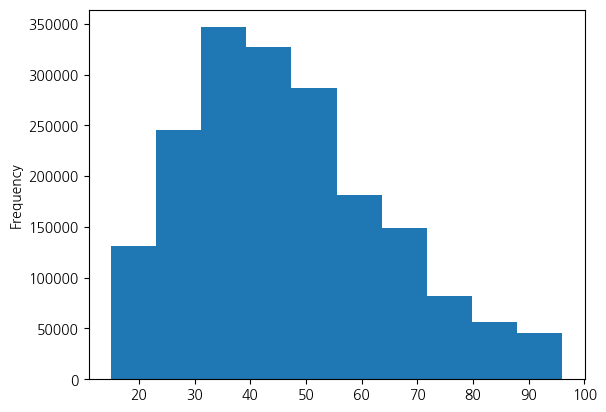

In [59]:
data['age'].plot(kind='hist')

In [63]:
# 연령이 높은 경우가 대부분임을 확인 가능
data.groupby('age')['is_fraud'].mean().sort_values(ascending=False).head(20)

age
18   1.000
95   1.000
88   0.016
77   0.012
80   0.012
24   0.011
86   0.010
63   0.010
96   0.010
57   0.009
83   0.009
59   0.009
52   0.009
79   0.009
93   0.008
56   0.008
84   0.008
82   0.007
19   0.007
81   0.007
Name: is_fraud, dtype: float64

In [67]:
data[data['age'] == 18]

,trans_date_trans_time,category,amt,gender,city_pop,job,dob,is_fraud,amt_iqr_max,amt_zscore,cat_amt_zscore,home_merch_dist,dist_zscore,age
1569725,2020-09-30 07:18:02,gas_transport,11.500,M,314,Chemical engineer,2002-03-17,1,2528.157,-1.304,NaN,84.512,0.334,18
1570625,2020-09-30 20:41:56,shopping_net,1017.050,M,314,Chemical engineer,2002-03-17,1,2528.157,0.699,0.646,53.732,-0.552,18
1570729,2020-09-30 22:10:03,shopping_net,943.120,M,314,Chemical engineer,2002-03-17,1,2528.157,0.552,-0.041,72.870,-0.001,18
1570761,2020-09-30 22:34:21,shopping_net,752.020,M,314,Chemical engineer,2002-03-17,1,2528.157,0.171,-1.816,38.285,-0.996,18
1570818,2020-09-30 23:17:10,travel,10.030,M,314,Chemical engineer,2002-03-17,1,2528.157,-1.307,0.707,67.577,-0.153,18
1570829,2020-09-30 23:22:55,shopping_net,879.090,M,314,Chemical engineer,2002-03-17,1,2528.157,0.424,-0.636,112.646,1.144,18
1570853,2020-09-30 23:41:38,shopping_pos,1320.920,M,314,Chemical engineer,2002-03-17,1,2528.157,1.304,NaN,23.660,-1.417,18
1572422,2020-10-01 22:22:21,shopping_net,1020.620,M,314,Chemical engineer,2002-03-17,1,2528.157,0.706,0.679,23.478,-1.423,18
1572425,2020-10-01 22:26:27,misc_pos,9.340,M,314,Chemical engineer,2002-03-17,1,2528.157,-1.308,NaN,136.677,1.836,18
1572428,2020-10-01 22:28:20,shopping_net,1075.700,M,314,Chemical engineer,2002-03-17,1,2528.157,0.816,1.191,81.901,0.259,18


In [68]:
data[data['age'] == 95]

,trans_date_trans_time,category,amt,gender,city_pop,job,dob,is_fraud,amt_iqr_max,amt_zscore,cat_amt_zscore,home_merch_dist,dist_zscore,age
93519,2019-02-25 00:28:40,grocery_pos,287.450,F,4431,Comptroller,1925-08-29,1,1614.925,-0.647,-0.964,8.022,-1.623,95
93788,2019-02-25 03:50:18,grocery_pos,320.830,F,4431,Comptroller,1925-08-29,1,1614.925,-0.555,1.570,101.182,0.793,95
95582,2019-02-25 22:15:35,misc_net,840.980,F,4431,Comptroller,1925-08-29,1,1614.925,0.866,0.707,61.673,-0.231,95
95593,2019-02-25 22:21:02,shopping_net,1085.730,F,4431,Comptroller,1925-08-29,1,1614.925,1.535,-0.707,36.038,-0.896,95
95620,2019-02-25 22:31:28,grocery_pos,304.930,F,4431,Comptroller,1925-08-29,1,1614.925,-0.599,0.363,64.771,-0.151,95
95821,2019-02-25 23:59:19,misc_net,803.490,F,4431,Comptroller,1925-08-29,1,1614.925,0.764,-0.707,89.165,0.482,95
95928,2019-02-26 01:17:18,gas_transport,10.910,F,4431,Comptroller,1925-08-29,1,1614.925,-1.402,NaN,124.454,1.397,95
95962,2019-02-26 01:45:08,grocery_pos,293.040,F,4431,Comptroller,1925-08-29,1,1614.925,-0.631,-0.540,84.967,0.373,95
96087,2019-02-26 03:24:44,grocery_pos,294.510,F,4431,Comptroller,1925-08-29,1,1614.925,-0.627,-0.428,20.735,-1.293,95
98001,2019-02-26 22:48:37,shopping_net,1091.470,F,4431,Comptroller,1925-08-29,1,1614.925,1.551,0.707,62.821,-0.201,95


In [69]:
data.columns

Index(['trans_date_trans_time', 'category', 'amt', 'gender', 'city_pop', 'job',
       'dob', 'is_fraud', 'amt_iqr_max', 'amt_zscore', 'cat_amt_zscore',
       'home_merch_dist', 'dist_zscore', 'age'],
      dtype='object')

### 컬럼 확인 및 정리
- trans_date_trans_time, dob 이를 제외한 나머지 컬럼들을 최종 데이터셋으로 활용

In [71]:
data = data.drop(['trans_date_trans_time', 'dob'], axis=1)

# 홀드아웃(훈련데이터, 테스트 데이터로 분리)
- 종속변수(target), 독립변수 분리, 훈련/테스트 데이터로 나누기

In [73]:
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

In [99]:
X.columns

Index(['category', 'amt', 'gender', 'city_pop', 'job', 'amt_iqr_max',
       'amt_zscore', 'cat_amt_zscore', 'home_merch_dist', 'dist_zscore',
       'age'],
      dtype='object')

In [100]:
X = pd.get_dummies(X, drop_first=True)
X

,amt,city_pop,amt_iqr_max,amt_zscore,cat_amt_zscore,home_merch_dist,dist_zscore,age,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,"job_Accountant, chartered","job_Accountant, chartered certified","job_Accountant, chartered public finance",job_Accounting technician,job_Acupuncturist,job_Administrator,"job_Administrator, arts","job_Administrator, charities/voluntary organisations","job_Administrator, education","job_Administrator, local government",job_Advertising account executive,job_Advertising account planner,job_Advertising copywriter,job_Advice worker,job_Aeronautical engineer,job_Agricultural consultant,job_Aid worker,job_Air broker,job_Air cabin crew,job_Air traffic controller,job_Airline pilot,job_Ambulance person,job_Amenity horticulturist,job_Analytical chemist,job_Animal nutritionist,job_Animal technologist,job_Animator,job_Applications developer,job_Arboriculturist,job_Archaeologist,job_Architect,job_Architectural technologist,job_Archivist,job_Armed forces logistics/support/administrative officer,job_Armed forces technical officer,job_Armed forces training and education officer,job_Art gallery manager,job_Art therapist,job_Artist,job_Arts development officer,job_Associate Professor,job_Audiological scientist,job_Barista,job_Barrister,job_Barrister's clerk,"job_Biochemist, clinical",job_Biomedical engineer,job_Biomedical scientist,job_Bookseller,job_Broadcast engineer,job_Broadcast journalist,job_Broadcast presenter,job_Building control surveyor,job_Building services engineer,job_Building surveyor,"job_Buyer, industrial","job_Buyer, retail",job_Cabin crew,job_Call centre manager,job_Camera operator,job_Careers adviser,job_Careers information officer,job_Cartographer,job_Catering manager,job_Ceramics designer,job_Charity fundraiser,job_Charity officer,job_Chartered accountant,job_Chartered legal executive (England and Wales),job_Chartered loss adjuster,job_Chartered public finance accountant,job_Chemical engineer,"job_Chemist, analytical",job_Chief Executive Officer,job_Chief Financial Officer,job_Chief Marketing Officer,job_Chief Operating Officer,job_Chief Strategy Officer,job_Chief Technology Officer,job_Chief of Staff,job_Child psychotherapist,job_Chiropodist,job_Civil Service administrator,job_Civil Service fast streamer,"job_Civil engineer, contracting",job_Claims inspector/assessor,job_Clinical biochemist,job_Clinical cytogeneticist,job_Clinical psychologist,job_Clinical research associate,job_Clothing/textile technologist,job_Colour technologist,job_Commercial horticulturist,job_Commercial/residential surveyor,job_Commissioning editor,job_Communications engineer,job_Community arts worker,job_Community development worker,job_Community education officer,job_Community pharmacist,job_Company secretary,job_Comptroller,"job_Conservation officer, historic buildings","job_Conservator, furniture","job_Conservator, museum/gallery",job_Contracting civil engineer,job_Contractor,job_Control and instrumentation engineer,job_Copy,"job_Copywriter, advertising",job_Corporate investment banker,job_Counselling psychologist,job_Counsellor,job_Curator,job_Cytogeneticist,job_Dance movement psychotherapist,job_Dancer,job_Data scientist,job_Database administrator,job_Dealer,"job_Designer, ceramics/pottery","job_Designer, exhibition/display","job_Designer, furniture","job_Designer, industrial/product","job_Designer, interior/spatial","job_Designer, jewellery","job_Designer, multimedia","job_Designer, television/film set","job_Designer, textile","job_Development worker, community","job_Development worker, international aid",job_Diagnostic radiographer,job_Dispensing optician,"job_Doctor, general practice","job_Doctor, hospital",job_Drilling engineer,job_Early years teacher,job_Ecologist,job_Economist,"job_Editor, 

In [103]:
# 0과 1의 비율 확인 -> 매우 불균형한 데이터임을 확인 가능
y.value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

In [80]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

### 홀드아웃 
- train, valid, test
- Valid Sets
    - 훈련용도도 아닌, 최종 테스트용도도 아닌 중간 평가용 데이터 분할
    - 하이퍼파라미터 튜닝: 학습률, 트리 깊이, 정규화 계수 등 모델 설정을 검증 세트 성능 기준으로 최적화
    - 모델 선택: 여러 알고리즘(A, B, C)을 비교해, 검증 세트에서 성능이 가장 좋은 모델을 선택
    - 과적합 방지: 훈련 세트에 과도하게 맞춘 모델인지, 아직 일반화 능력을 갖췄는지 중간 점검

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, stratify=y_valid, random_state=42)

In [106]:
print(len(X_train), len(X_valid), len(X_test))
print(len(y_train), len(y_valid), len(y_test))

1111436 370479 370479
1111436 370479 370479


In [107]:
X_train.columns

Index(['amt', 'city_pop', 'amt_iqr_max', 'amt_zscore', 'cat_amt_zscore',
       'home_merch_dist', 'dist_zscore', 'age', 'category_food_dining',
       'category_gas_transport',
       ...
       'job_Visual merchandiser', 'job_Volunteer coordinator',
       'job_Warden/ranger', 'job_Warehouse manager',
       'job_Waste management officer', 'job_Water engineer',
       'job_Water quality scientist', 'job_Web designer',
       'job_Wellsite geologist', 'job_Writer'],
      dtype='object', length=518)

In [91]:
y_train.value_counts()

is_fraud
0    1105645
1       5791
Name: count, dtype: int64

In [93]:
# 동일한 비율로 들어가기 위함
5791 / (1105645+5791) * 100

0.5210376485915518

In [94]:
y_valid.value_counts()

is_fraud
0    368549
1      1930
Name: count, dtype: int64

In [95]:
# 동일한 비율로 들어가기 위함
1930 / (1930+368549) * 100

0.5209472061844261

In [96]:
y_test.value_counts()

is_fraud
0    368549
1      1930
Name: count, dtype: int64

In [102]:
# 동일한 비율로 들어가기 위함
1930 / (1930+368549) * 100

0.5209472061844261

## DecisionTree 분석

In [112]:
# depth의 깊이는 204
dtc = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dtc.fit(X_train, y_train)
pred = dtc.predict(X_valid)
print(classification_report(y_valid, pred))

print('='*30, f'test_result', '='*30)
test_pred = dtc.predict(X_test)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368549
           1       0.61      0.67      0.64      1930

    accuracy                           1.00    370479
   macro avg       0.81      0.83      0.82    370479
weighted avg       1.00      1.00      1.00    370479

============================== test_result ==============================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368549
           1       0.63      0.69      0.66      1930

    accuracy                           1.00    370479
   macro avg       0.81      0.84      0.83    370479
weighted avg       1.00      1.00      1.00    370479



In [121]:
print(dtc.get_params())

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [122]:
print(dtc.tree_.max_depth)

204


In [114]:
importance = pd.DataFrame(dtc.feature_importances_, columns=['importance'])
column_name = pd.DataFrame(dtc.feature_names_in_, columns=['column'])

In [115]:
dtc_im_col = pd.concat([column_name, importance], axis=1)
dtc_im_col

,column,importance
0,amt,0.661
1,city_pop,0.016
2,amt_iqr_max,0.012
3,amt_zscore,0.008
4,cat_amt_zscore,0.162
...,...,...
513,job_Water engineer,0.000
514,job_Water quality scientist,0.000
515,job_Web designer,0.000
516,job_Wellsite geologist,0.000


In [117]:
dtc_im_col.sort_values(by='importance', ascending=False).head(20)

,column,importance
0,amt,0.661
4,cat_amt_zscore,0.162
7,age,0.020
1,city_pop,0.016
10,category_grocery_net,0.014
2,amt_iqr_max,0.012
11,category_grocery_pos,0.012
20,category_travel,0.012
8,category_food_dining,0.011
13,category_home,0.011


In [109]:
%%time

for i in range(1,11):
    dtc = DecisionTreeClassifier(max_depth=i, class_weight='balanced', random_state=42)
    dtc.fit(X_train, y_train)
    pred = dtc.predict(X_valid)
    print(classification_report(y_valid, pred))

    print('='*30, f'test_result_{i}', '='*30)
    test_pred = dtc.predict(X_test)
    print(classification_report(y_test, test_pred))
    print()

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    368549
           1       0.12      0.75      0.21      1930

    accuracy                           0.97    370479
   macro avg       0.56      0.86      0.60    370479
weighted avg       0.99      0.97      0.98    370479

============================== test_result_1 ==============================
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    368549
           1       0.13      0.77      0.22      1930

    accuracy                           0.97    370479
   macro avg       0.56      0.87      0.60    370479
weighted avg       0.99      0.97      0.98    370479


              precision    recall  f1-score   support

           0       1.00      0.97      0.99    368549
           1       0.15      0.84      0.25      1930

    accuracy                           0.97    370479
   macro avg       0.57      0.91      0.62    3704

## RandomForest 분석

In [118]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=10)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_valid)
print('='*30, f'valid_result', '='*30)
print(classification_report(y_valid, pred), end='\n\n')

print('='*30, f'test_result', '='*30)
test_pred = rfc.predict(X_test)
print(classification_report(y_test, test_pred), end='\n\n')

============================== valid_result ==============================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368549
           1       0.84      0.64      0.73      1930

    accuracy                           1.00    370479
   macro avg       0.92      0.82      0.86    370479
weighted avg       1.00      1.00      1.00    370479


============================== test_result ==============================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368549
           1       0.86      0.65      0.74      1930

    accuracy                           1.00    370479
   macro avg       0.93      0.83      0.87    370479
weighted avg       1.00      1.00      1.00    370479




In [129]:
depths = [estimator.tree_.max_depth for estimator in rfc.estimators_]
print('각 트리의 최대 깊이 =', depths)
print()
print('평균 깊이 =', sum(depths) / len(depths))
print('최소 깊이 =', min(depths),'최대 깊이 =',max(depths))

각 트리의 최대 깊이 = [210, 137, 112, 154, 160, 220, 162, 171, 207, 208, 178, 166, 247, 213, 158, 152, 198, 169, 198, 161, 178, 165, 166, 146, 202, 171, 135, 174, 160, 138, 207, 127, 127, 166, 142, 158, 188, 214, 186, 148, 206, 227, 190, 158, 167, 181, 139, 158, 157, 175, 146, 148, 203, 218, 230, 147, 235, 215, 167, 183, 190, 131, 198, 132, 159, 188, 224, 190, 162, 153, 140, 141, 122, 143, 129, 164, 150, 126, 128, 231, 134, 197, 209, 136, 192, 124, 214, 193, 173, 148, 143, 138, 195, 210, 130, 226, 162, 222, 202, 215]

평균 깊이 = 172.93
최소 깊이 = 112 최대 깊이 = 247


## XGBoost 분석

In [134]:
y_train.value_counts()

is_fraud
0    1105645
1       5791
Name: count, dtype: int64

### XGBoost 에서 소수 클래스에 가중치 주는 경우 값 계산
- n_nagative / n_positive 

In [135]:
1105645 / 5791

190.92471075807288

In [136]:
# 소수 클래스에 가중치 부여 -> 190
xgb = XGBClassifier(scale_pos_weight=190 ,n_jobs=10, random_state=42)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_valid)
print('='*30, f'valid_result', '='*30)
print(classification_report(y_valid, pred), end='\n\n')

print('='*30, f'test_result', '='*30)
test_pred = xgb.predict(X_test)
print(classification_report(y_test, test_pred), end='\n\n')


============================== valid_result ==============================
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    368549
           1       0.19      0.95      0.31      1930

    accuracy                           0.98    370479
   macro avg       0.59      0.97      0.65    370479
weighted avg       1.00      0.98      0.99    370479


============================== test_result ==============================
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    368549
           1       0.19      0.95      0.32      1930

    accuracy                           0.98    370479
   macro avg       0.60      0.97      0.65    370479
weighted avg       1.00      0.98      0.99    370479




## CatBoost 분석

In [140]:
%%time

cbc = CatBoostClassifier(class_weights=[1, 190], thread_count=10, random_state=42)
cbc.fit(X_train, y_train)
pred = cbc.predict(X_valid)
print('='*30, f'valid_result', '='*30)
print(classification_report(y_valid, pred), end='\n\n')

print('='*30, f'test_result', '='*30)
test_pred = cbc.predict(X_test)
print(classification_report(y_test, test_pred), end='\n\n')


Learning rate set to 0.205839
0:	learn: 0.4764484	total: 403ms	remaining: 6m 42s
1:	learn: 0.3813003	total: 653ms	remaining: 5m 25s
2:	learn: 0.3110306	total: 875ms	remaining: 4m 50s
3:	learn: 0.2747007	total: 1.11s	remaining: 4m 35s
4:	learn: 0.2394786	total: 1.36s	remaining: 4m 31s
5:	learn: 0.2194895	total: 1.56s	remaining: 4m 18s
6:	learn: 0.1965085	total: 1.79s	remaining: 4m 13s
7:	learn: 0.1870707	total: 2s	remaining: 4m 8s
8:	learn: 0.1720559	total: 2.26s	remaining: 4m 9s
9:	learn: 0.1628529	total: 2.49s	remaining: 4m 6s
10:	learn: 0.1550960	total: 2.74s	remaining: 4m 6s
11:	learn: 0.1478856	total: 2.97s	remaining: 4m 4s
12:	learn: 0.1349576	total: 3.18s	remaining: 4m 1s
13:	learn: 0.1306729	total: 3.49s	remaining: 4m 5s
14:	learn: 0.1274014	total: 3.69s	remaining: 4m 2s
15:	learn: 0.1220365	total: 3.92s	remaining: 4m 1s
16:	learn: 0.1152573	total: 4.15s	remaining: 3m 59s
17:	learn: 0.1135054	total: 4.37s	remaining: 3m 58s
18:	learn: 0.1093977	total: 4.64s	remaining: 3m 59s
19:	

158:	learn: 0.0504520	total: 34.7s	remaining: 3m 3s
159:	learn: 0.0503260	total: 34.9s	remaining: 3m 3s
160:	learn: 0.0502463	total: 35s	remaining: 3m 2s
161:	learn: 0.0501388	total: 35.2s	remaining: 3m 2s
162:	learn: 0.0500349	total: 35.4s	remaining: 3m 1s
163:	learn: 0.0498887	total: 35.6s	remaining: 3m 1s
164:	learn: 0.0497550	total: 35.8s	remaining: 3m 1s
165:	learn: 0.0495169	total: 36s	remaining: 3m 1s
166:	learn: 0.0492263	total: 36.2s	remaining: 3m
167:	learn: 0.0491267	total: 36.4s	remaining: 3m
168:	learn: 0.0489817	total: 36.6s	remaining: 3m
169:	learn: 0.0488549	total: 36.8s	remaining: 2m 59s
170:	learn: 0.0487739	total: 37s	remaining: 2m 59s
171:	learn: 0.0486293	total: 37.2s	remaining: 2m 59s
172:	learn: 0.0485580	total: 37.4s	remaining: 2m 58s
173:	learn: 0.0484898	total: 37.6s	remaining: 2m 58s
174:	learn: 0.0484071	total: 37.8s	remaining: 2m 58s
175:	learn: 0.0483475	total: 38s	remaining: 2m 57s
176:	learn: 0.0482569	total: 38.2s	remaining: 2m 57s
177:	learn: 0.0481673

315:	learn: 0.0353256	total: 1m 5s	remaining: 2m 22s
316:	learn: 0.0352759	total: 1m 6s	remaining: 2m 22s
317:	learn: 0.0351903	total: 1m 6s	remaining: 2m 22s
318:	learn: 0.0351215	total: 1m 6s	remaining: 2m 21s
319:	learn: 0.0350628	total: 1m 6s	remaining: 2m 21s
320:	learn: 0.0349912	total: 1m 6s	remaining: 2m 21s
321:	learn: 0.0349572	total: 1m 7s	remaining: 2m 21s
322:	learn: 0.0349060	total: 1m 7s	remaining: 2m 21s
323:	learn: 0.0348663	total: 1m 7s	remaining: 2m 20s
324:	learn: 0.0348061	total: 1m 7s	remaining: 2m 20s
325:	learn: 0.0347263	total: 1m 7s	remaining: 2m 20s
326:	learn: 0.0346976	total: 1m 8s	remaining: 2m 20s
327:	learn: 0.0345919	total: 1m 8s	remaining: 2m 19s
328:	learn: 0.0345708	total: 1m 8s	remaining: 2m 19s
329:	learn: 0.0345335	total: 1m 8s	remaining: 2m 19s
330:	learn: 0.0344653	total: 1m 8s	remaining: 2m 19s
331:	learn: 0.0344115	total: 1m 9s	remaining: 2m 18s
332:	learn: 0.0343487	total: 1m 9s	remaining: 2m 18s
333:	learn: 0.0342739	total: 1m 9s	remaining: 

470:	learn: 0.0284616	total: 1m 35s	remaining: 1m 47s
471:	learn: 0.0284606	total: 1m 35s	remaining: 1m 47s
472:	learn: 0.0284014	total: 1m 35s	remaining: 1m 46s
473:	learn: 0.0283654	total: 1m 36s	remaining: 1m 46s
474:	learn: 0.0283182	total: 1m 36s	remaining: 1m 46s
475:	learn: 0.0282794	total: 1m 36s	remaining: 1m 46s
476:	learn: 0.0282553	total: 1m 36s	remaining: 1m 45s
477:	learn: 0.0282239	total: 1m 36s	remaining: 1m 45s
478:	learn: 0.0281903	total: 1m 37s	remaining: 1m 45s
479:	learn: 0.0281586	total: 1m 37s	remaining: 1m 45s
480:	learn: 0.0281452	total: 1m 37s	remaining: 1m 45s
481:	learn: 0.0281064	total: 1m 37s	remaining: 1m 44s
482:	learn: 0.0280554	total: 1m 37s	remaining: 1m 44s
483:	learn: 0.0280234	total: 1m 38s	remaining: 1m 44s
484:	learn: 0.0279908	total: 1m 38s	remaining: 1m 44s
485:	learn: 0.0279652	total: 1m 38s	remaining: 1m 44s
486:	learn: 0.0279192	total: 1m 38s	remaining: 1m 43s
487:	learn: 0.0278883	total: 1m 38s	remaining: 1m 43s
488:	learn: 0.0278883	total:

624:	learn: 0.0255814	total: 2m 2s	remaining: 1m 13s
625:	learn: 0.0255475	total: 2m 3s	remaining: 1m 13s
626:	learn: 0.0255390	total: 2m 3s	remaining: 1m 13s
627:	learn: 0.0255390	total: 2m 3s	remaining: 1m 13s
628:	learn: 0.0255389	total: 2m 3s	remaining: 1m 12s
629:	learn: 0.0255389	total: 2m 3s	remaining: 1m 12s
630:	learn: 0.0255384	total: 2m 3s	remaining: 1m 12s
631:	learn: 0.0255384	total: 2m 4s	remaining: 1m 12s
632:	learn: 0.0255166	total: 2m 4s	remaining: 1m 12s
633:	learn: 0.0255161	total: 2m 4s	remaining: 1m 11s
634:	learn: 0.0255160	total: 2m 4s	remaining: 1m 11s
635:	learn: 0.0255160	total: 2m 4s	remaining: 1m 11s
636:	learn: 0.0255097	total: 2m 4s	remaining: 1m 11s
637:	learn: 0.0254803	total: 2m 5s	remaining: 1m 10s
638:	learn: 0.0254556	total: 2m 5s	remaining: 1m 10s
639:	learn: 0.0254555	total: 2m 5s	remaining: 1m 10s
640:	learn: 0.0254157	total: 2m 5s	remaining: 1m 10s
641:	learn: 0.0253810	total: 2m 5s	remaining: 1m 10s
642:	learn: 0.0252695	total: 2m 5s	remaining: 

781:	learn: 0.0228822	total: 2m 31s	remaining: 42.3s
782:	learn: 0.0228612	total: 2m 31s	remaining: 42.1s
783:	learn: 0.0228374	total: 2m 31s	remaining: 41.9s
784:	learn: 0.0227912	total: 2m 32s	remaining: 41.7s
785:	learn: 0.0227802	total: 2m 32s	remaining: 41.5s
786:	learn: 0.0227323	total: 2m 32s	remaining: 41.3s
787:	learn: 0.0227166	total: 2m 32s	remaining: 41.1s
788:	learn: 0.0227108	total: 2m 32s	remaining: 40.9s
789:	learn: 0.0226684	total: 2m 33s	remaining: 40.7s
790:	learn: 0.0226493	total: 2m 33s	remaining: 40.5s
791:	learn: 0.0226129	total: 2m 33s	remaining: 40.3s
792:	learn: 0.0225888	total: 2m 33s	remaining: 40.1s
793:	learn: 0.0225697	total: 2m 33s	remaining: 39.9s
794:	learn: 0.0225475	total: 2m 34s	remaining: 39.7s
795:	learn: 0.0225422	total: 2m 34s	remaining: 39.6s
796:	learn: 0.0225108	total: 2m 34s	remaining: 39.4s
797:	learn: 0.0224790	total: 2m 34s	remaining: 39.2s
798:	learn: 0.0224787	total: 2m 34s	remaining: 39s
799:	learn: 0.0224606	total: 2m 35s	remaining: 3

937:	learn: 0.0206476	total: 2m 59s	remaining: 11.9s
938:	learn: 0.0206097	total: 3m	remaining: 11.7s
939:	learn: 0.0205934	total: 3m	remaining: 11.5s
940:	learn: 0.0205713	total: 3m	remaining: 11.3s
941:	learn: 0.0205499	total: 3m	remaining: 11.1s
942:	learn: 0.0205378	total: 3m	remaining: 10.9s
943:	learn: 0.0205192	total: 3m 1s	remaining: 10.7s
944:	learn: 0.0205125	total: 3m 1s	remaining: 10.6s
945:	learn: 0.0205078	total: 3m 1s	remaining: 10.4s
946:	learn: 0.0205022	total: 3m 1s	remaining: 10.2s
947:	learn: 0.0204846	total: 3m 1s	remaining: 9.98s
948:	learn: 0.0204578	total: 3m 2s	remaining: 9.78s
949:	learn: 0.0204348	total: 3m 2s	remaining: 9.59s
950:	learn: 0.0204317	total: 3m 2s	remaining: 9.4s
951:	learn: 0.0203947	total: 3m 2s	remaining: 9.21s
952:	learn: 0.0203599	total: 3m 2s	remaining: 9.02s
953:	learn: 0.0203590	total: 3m 2s	remaining: 8.82s
954:	learn: 0.0203423	total: 3m 3s	remaining: 8.63s
955:	learn: 0.0203067	total: 3m 3s	remaining: 8.44s
956:	learn: 0.0202988	total

## LightGBM 분석
- 컬럼을 다시 설정

In [150]:
new_cols=[]
for idx, col in enumerate(X.columns):
    new_cols.append(col.replace(', ', '_').replace('/', '_').replace(' ', '_').replace('(', '').replace(')', '').replace("'", ''))

In [151]:
print(len(new_cols))
print(len(X.columns))

518
518


In [152]:
X.columns = new_cols
X

,amt,city_pop,amt_iqr_max,amt_zscore,cat_amt_zscore,home_merch_dist,dist_zscore,age,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,job_Accountant_chartered,job_Accountant_chartered_certified,job_Accountant_chartered_public_finance,job_Accounting_technician,job_Acupuncturist,job_Administrator,job_Administrator_arts,job_Administrator_charities_voluntary_organisations,job_Administrator_education,job_Administrator_local_government,job_Advertising_account_executive,job_Advertising_account_planner,job_Advertising_copywriter,job_Advice_worker,job_Aeronautical_engineer,job_Agricultural_consultant,job_Aid_worker,job_Air_broker,job_Air_cabin_crew,job_Air_traffic_controller,job_Airline_pilot,job_Ambulance_person,job_Amenity_horticulturist,job_Analytical_chemist,job_Animal_nutritionist,job_Animal_technologist,job_Animator,job_Applications_developer,job_Arboriculturist,job_Archaeologist,job_Architect,job_Architectural_technologist,job_Archivist,job_Armed_forces_logistics_support_administrative_officer,job_Armed_forces_technical_officer,job_Armed_forces_training_and_education_officer,job_Art_gallery_manager,job_Art_therapist,job_Artist,job_Arts_development_officer,job_Associate_Professor,job_Audiological_scientist,job_Barista,job_Barrister,job_Barristers_clerk,job_Biochemist_clinical,job_Biomedical_engineer,job_Biomedical_scientist,job_Bookseller,job_Broadcast_engineer,job_Broadcast_journalist,job_Broadcast_presenter,job_Building_control_surveyor,job_Building_services_engineer,job_Building_surveyor,job_Buyer_industrial,job_Buyer_retail,job_Cabin_crew,job_Call_centre_manager,job_Camera_operator,job_Careers_adviser,job_Careers_information_officer,job_Cartographer,job_Catering_manager,job_Ceramics_designer,job_Charity_fundraiser,job_Charity_officer,job_Chartered_accountant,job_Chartered_legal_executive_England_and_Wales,job_Chartered_loss_adjuster,job_Chartered_public_finance_accountant,job_Chemical_engineer,job_Chemist_analytical,job_Chief_Executive_Officer,job_Chief_Financial_Officer,job_Chief_Marketing_Officer,job_Chief_Operating_Officer,job_Chief_Strategy_Officer,job_Chief_Technology_Officer,job_Chief_of_Staff,job_Child_psychotherapist,job_Chiropodist,job_Civil_Service_administrator,job_Civil_Service_fast_streamer,job_Civil_engineer_contracting,job_Claims_inspector_assessor,job_Clinical_biochemist,job_Clinical_cytogeneticist,job_Clinical_psychologist,job_Clinical_research_associate,job_Clothing_textile_technologist,job_Colour_technologist,job_Commercial_horticulturist,job_Commercial_residential_surveyor,job_Commissioning_editor,job_Communications_engineer,job_Community_arts_worker,job_Community_development_worker,job_Community_education_officer,job_Community_pharmacist,job_Company_secretary,job_Comptroller,job_Conservation_officer_historic_buildings,job_Conservator_furniture,job_Conservator_museum_gallery,job_Contracting_civil_engineer,job_Contractor,job_Control_and_instrumentation_engineer,job_Copy,job_Copywriter_advertising,job_Corporate_investment_banker,job_Counselling_psychologist,job_Counsellor,job_Curator,job_Cytogeneticist,job_Dance_movement_psychotherapist,job_Dancer,job_Data_scientist,job_Database_administrator,job_Dealer,job_Designer_ceramics_pottery,job_Designer_exhibition_display,job_Designer_furniture,job_Designer_industrial_product,job_Designer_interior_spatial,job_Designer_jewellery,job_Designer_multimedia,job_Designer_television_film_set,job_Designer_textile,job_Development_worker_community,job_Development_worker_international_aid,job_Diagnostic_radiographer,job_Dispensing_optician,job_Doctor_general_practice,job_Doctor_hospital,job_Drilling_engineer,job_Early_years_teacher,job_Ecologist,job_Economist,job_Editor_commissioning,job_Editor_film_video,job_Editor_magazine_features,job_Education_administrator

In [153]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, stratify=y_valid, random_state=42)

In [154]:
%%time

lgbm = LGBMClassifier(class_weight='balanced' ,n_jobs=10, random_state=42)
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_valid)
print('='*30, f'valid_result', '='*30)
print(classification_report(y_valid, pred), end='\n\n')

print('='*30, f'test_result', '='*30)
test_pred = lgbm.predict(X_test)
print(classification_report(y_test, test_pred), end='\n\n')


[LightGBM] [Info] Number of positive: 5791, number of negative: 1105645
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 1111436, number of used features: 502
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
============================== valid_result ==============================
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    368549
           1       0.17      0.97      0.28      1930

    accuracy                           0.97    370479
   macro avg       0.58      0.97      0.64    370479
weighted avg       1.00      0.97      0.98    370479


============================== test_result ==============================
              precision  

# 랜덤포레스트로 하이퍼파라미터 튜닝
- 랜덤포레스트 모델이 가장 효과적인 모델로 확인됨

In [155]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=10)

In [157]:
params = dict(criterion=['gini', 'entropy', 'log_loss'],
             max_depth = [150, 160, 170, 180, 200],
             random_state=[42],
             class_weight = [None, 'balanced'])

In [1]:
# 하이퍼파라미터 과정이 너무 오래 걸리고 컴퓨터 다운되어 나중에 확인
# %%time
# rand_cv = RandomizedSearchCV(rfc, param_distributions=params, cv=5, scoring='f1',n_jobs=10, random_state=42)

# rand_cv.fit(X_train, y_train)
# pred = rand_cv.predict(X_valid)
# print('='*30, f'valid_result', '='*30)
# print('bset_params: ', rand_cv.best_params_)
# print('best_scores: ', rand_cv.best_score_)
# print(classification_report(y_valid, pred), end='\n\n')

# print('='*30, f'test_result', '='*30)
# test_pred = rand_cv.predict(X_test)
# print(classification_report(y_test, test_pred), end='\n\n')

# 금융 사기(Financial Fraud)
- 금융 거래에서 속이거나 기만하여 자산이나 돈을 획득하는 행위
- 주요 유형
    - 신용카드 사기
    - 피싱, 신분 도용
    - 보험 사기
    - 돈세탁

## 금융 사기 대응법
- 고객의 거래 패턴 분석, 비정상 거래 포착
- 전문가 기반 규칙 - 전문가들의 경험에 의한 사기 탐지
- 통계 기반 분석 - 수학적 모델, 통계학 기반 모델로 이상 탐지
- 머신러닝 기반 분석 - 대규모 데이터 학습, 전문가 기반, 통계 기반으로 찾지 못하는 사기도 탐지 가능(시스템 자원이 매우 많이 듦)

## 금융 사기 탐지의 어려움
- 사기 확인이 피해자의 불만 표현 등을 통해서 이루어지는 경우가 많음
- 사기 거래 자체가 적음 => 데이터 확보가 어려움(학습 데이터가 적음)
- 데이터 부족으로 인해 성능 좋은 모델 생성이 어려움
- 가상의 데이터를 인공적으로 생성하여 모델 생성에 활용


## 사기 방지와 고객 경험의 균형
- 정당한 거래가 차단되어 고객에게 좋지 않은 사용 경험을 주는 경우
- 엄격한 탐지 -> 사용자 불편 증가
- 관대한 탐지 -> 사기율이 증가할 수 있음
- 적절한 타협이 필요